In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 10,10

from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os

import gradcamutils

In [71]:
datagen = ImageDataGenerator(rescale=1./255)
test_it = datagen.flow_from_directory('RT_100/combined/', target_size=(128, 128))

Found 10629 images belonging to 3 classes.


In [72]:
model = load_model('model/f58b4_RT_100.h5')
model.summary()
model.evaluate_generator(test_it)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 30)      840       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 30)      120       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 30)        8130      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 30)        120       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 60)        16260 

[0.26422552180451314, 0.9464672]

In [37]:
model.predict_on_batch()

In [80]:
slow_paths = [os.path.join('RT_100', 'combined', '0', bts) for bts in os.listdir('RT_100/combined/0')]
fast_paths = [os.path.join('RT_100', 'combined', '1', bts) for bts in os.listdir('RT_100/combined/1')]
medium_paths = [os.path.join('RT_100', 'combined', '3', bts) for bts in os.listdir('RT_100/combined/3')]

def eval_predictions(model, paths, label):
    imgs = []
    for path in paths:
        img = np.array(load_img(path,target_size=(128,128)),dtype=np.float64)
        img = img/np.max(img)
        imgs.append(img)
    imgs = np.array(imgs)
    y = np.zeros((imgs.shape[0], 3))
    y[:, label] = 1
    preds = model.evaluate(imgs, y)
#     preds = np.where(preds == 0, 3, preds)
#     preds = np.where(preds == 2, 0, preds)
    print(preds)
    evals = np.equal(preds, label)
    decodes = [(path, _eval) for path,_eval in zip(paths, evals)]
    return decodes

In [82]:
decodes_slow = eval_predictions(model, fast_paths, 1)

5021/5021 [==============================] - 3s 630us/sample - loss: 0.2401 - accuracy: 0.9494
[0.24009156336919218, 0.94941247]


In [67]:
len(t)/len(decodes_slow)

0.5188209520015933

(224, 224)


ValueError: operands could not be broadcast together with shapes (224,224) (224,224,3) 

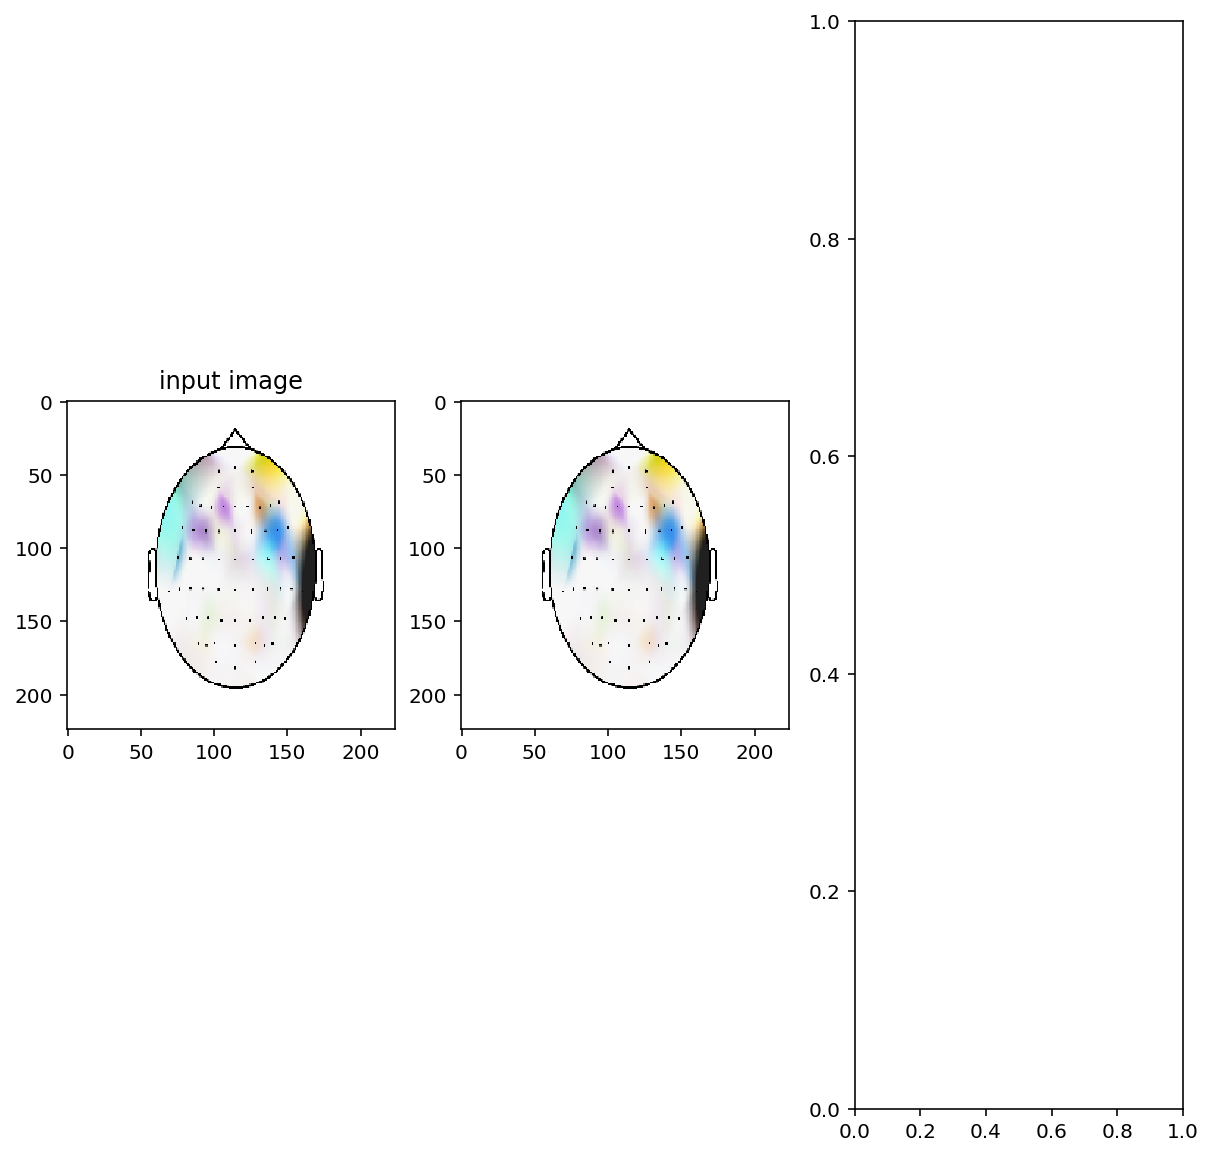

In [12]:
paths = ["RT_100/Samples_0/bts_700.png","RT_100/Samples_1/bts_192.png","RT_100/Samples_3/bts_129.png",
         "RT_100/Samples_0/bts_723.png", "RT_100/Samples_1/bts_203.png", "RT_100/Samples_3/bts_159.png"]
orig_imgs = []
grad_cams = []
grad_cam_pluses = []
for path in paths:
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    orig_imgs.append(orig_img)
    img = np.array(load_img(path,target_size=(128,128)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
#     predictions = model.predict(img)
#     top_n = 5
#     top = decode_predictions(predictions, top=top_n)[0]
#     cls = np.argsort(predictions[0])[-top_n:][::-1]
    
    gradcam=gradcamutils.grad_cam(model,img,layer_name='conv2d_5', H=224, W=224)
    grad_cams.append(gradcam)
    gradcamplus=gradcamutils.grad_cam_plus(model,img,layer_name='conv2d_5', H=224, W=224)
    grad_cam_pluses.append(gradcamplus)
    fig, ax = plt.subplots(nrows=1,ncols=3)
    plt.subplot(131)
    plt.imshow(orig_img)
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(orig_img)
    plt.imshow(gradcam*orig_img)
    plt.title("Grad-CAM")
    plt.subplot(133)
    plt.imshow(orig_img)
    plt.imshow(gradcamplus,alpha=0.6,cmap="jet")
    plt.title("Grad-CAM++")
    plt.show()

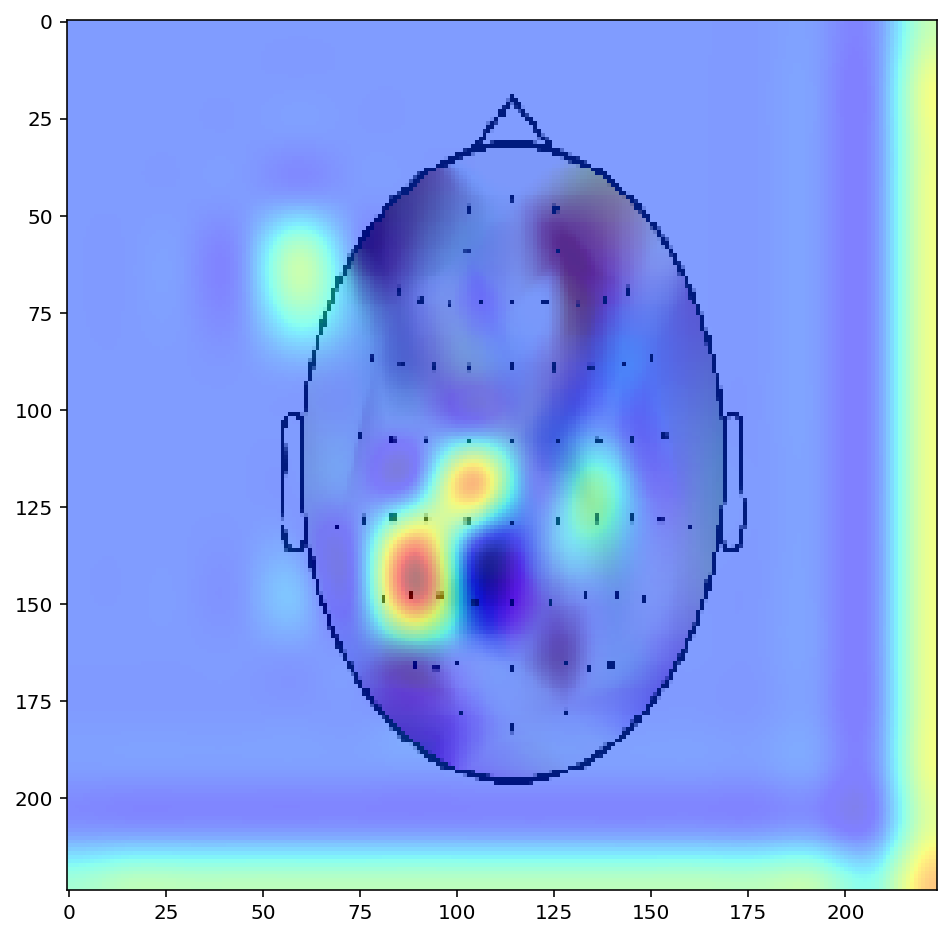

In [9]:
plt.figure()
plt.imshow(orig_imgs[3])
plt.imshow(grad_cams[3], alpha=0.5,cmap="jet")